We experimented with various methods, including DNNs, RNNs, LSTMs, and different architectures. The comment

"Selected" in the code cells indicates that both the selected architectures and predictions are the ones

highlighted in the paper.

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Bidirectional
from tensorflow.keras.layers import LSTM
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import numpy as np
import keras
from sklearn.manifold import TSNE
# processing imports
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from joblib import dump, load
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC


from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.

In [2]:
def report_heatmap(y_pred,y_test):
    
    # overall accuracy 
    acc = accuracy_score(y_test, y_pred)
    print( f'Overall Accuracy: {acc*100:.2f}%' )
    print("--------------------------")    
    
    # report
    print(classification_report(y_test, y_pred))
    figsize=(8,5)
    #y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [3]:
df = pd.read_csv('balanced_dataset.csv')

In [4]:
del df['Unnamed: 0']

In [5]:
df.head()

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_S0,conn_state_S1
0,3.103243,0.0,0.0,3.0,180.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.000000,-1.0,-1.0,2.0,80.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.000000,-1.0,-1.0,6.0,360.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.000000,-1.0,-1.0,2.0,80.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.000000,-1.0,-1.0,2.0,120.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [6]:
df['label'].value_counts()

0.0    961750
1.0    934971
Name: label, dtype: int64

In [7]:
df_train,df_test=train_test_split(df, test_size=0.25, random_state=42)

In [8]:
df_train.shape

(1422540, 15)

In [9]:
df_test.shape

(474181, 15)

In [10]:
x = df_train.drop(["label"], axis=1)
y = df_train["label"].values

In [11]:
type(x)

pandas.core.frame.DataFrame

In [12]:
type(y)

numpy.ndarray

In [13]:
x.shape

(1422540, 14)

# For Evaluation

In [14]:
x_vld= df_test.drop(["label"], axis=1)
y_vld = df_test["label"].values

In [15]:
type(y_vld)

numpy.ndarray

In [13]:
from sklearn import preprocessing

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_vld_scale = preprocessing.MinMaxScaler().fit_transform(x_vld.values)
#x_norm, x_anomaly = x_scale[y == 0], x_scale[y == 1]
#x_norm_valid, x_anomaly_valid = x_scale[y == 0], x_scale[y == 1]

In [29]:
type(x_scale)

numpy.ndarray

In [20]:
print(x_scale.max())
print(x_scale.min())

1.0000000000000002
0.0


In [17]:
x_vld_scale

array([[1.21368120e-03, 3.50769140e-05, 2.46306736e-02, ...,
        3.90577693e-02, 8.99813231e-01, 6.13712772e-03],
       [1.20761635e-03, 3.26582360e-05, 3.06198041e-02, ...,
        4.40658522e-02, 9.08072912e-01, 5.58683809e-03],
       [1.11391873e-03, 3.50769140e-05, 2.46306736e-02, ...,
        3.90577693e-02, 8.99813231e-01, 6.13712772e-03],
       ...,
       [1.31226229e-03, 4.48960818e-05, 2.62949130e-02, ...,
        3.71111153e-02, 9.02631830e-01, 6.59861279e-03],
       [1.11391873e-03, 3.50769140e-05, 2.46306736e-02, ...,
        3.90577693e-02, 8.99813231e-01, 6.13712772e-03],
       [1.07556912e-03, 4.35975243e-05, 3.27359890e-02, ...,
        2.33679231e-02, 9.49497545e-01, 5.34806863e-03]])

In [21]:
print(x_vld_scale.max())
print(x_vld_scale.min())

1.0000000000000002
0.0


Due to not getting good accuracy we didn't use scaled data

# LSTM+AE

In [16]:
#Selected

lstm_encoder = keras.models.Sequential([
keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 1]),
keras.layers.LSTM(5)
])
lstm_decoder = keras.models.Sequential([
keras.layers.RepeatVector(3, input_shape=[5]),
keras.layers.LSTM(5, return_sequences=True),
keras.layers.LSTM(10),
keras.layers.Dense(1, activation="sigmoid")
])
lstm_ae = keras.models.Sequential([lstm_encoder, lstm_decoder])

lstm_ae.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
lstm_ae.summary()
lstm_ae.fit(x, y,batch_size=100,epochs=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 5)                 800       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 966       
                                                                 
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
14226/14226 [==============================] - 185s 13ms/step - loss: 0.1456 - accuracy: 0.9355


14819/14819 [==============================] - 53s 4ms/step
Overall Accuracy: 94.39%
--------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    240571
         1.0       0.90      1.00      0.95    233610

    accuracy                           0.94    474181
   macro avg       0.95      0.94      0.94    474181
weighted avg       0.95      0.94      0.94    474181



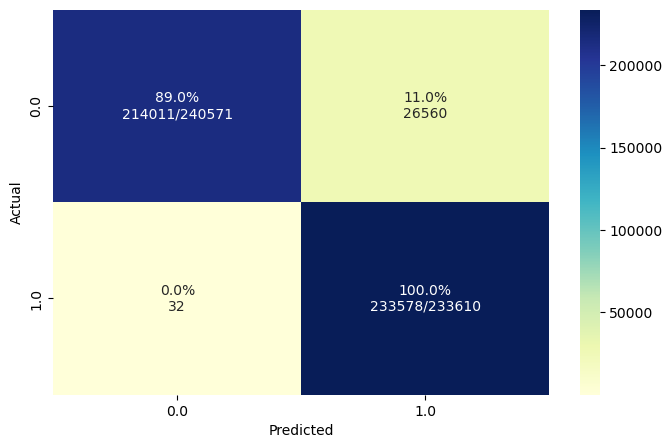

In [17]:
#Selected
y_pred_lstm=(lstm_ae.predict(x_vld)> 0.5)
report_heatmap(y_pred_lstm,y_vld)

# GRU+AE

In [20]:
# selected

gru_encoder = keras.models.Sequential([
keras.layers.GRU(10, return_sequences=True, input_shape=[None, 1]),
keras.layers.GRU(5)
])
gru_decoder = keras.models.Sequential([
keras.layers.RepeatVector(3, input_shape=[5]),
keras.layers.GRU(5, return_sequences=True),
keras.layers.GRU(10),
keras.layers.Dense(1, activation="sigmoid")
])
gru_ae = keras.models.Sequential([gru_encoder, gru_decoder])

gru_ae.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
gru_ae.summary()
gru_ae.fit(x, y,batch_size=100,epochs=2)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 5)                 800       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 966       
                                                                 
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
14226/14226 [==============================] - 176s 12ms/step - loss: 0.1252 - accuracy: 0.9439
Epoch 2/2
14226/14226 [==============================] - 168s 12ms/step - loss: 0.1250 - accuracy: 0.9436


14819/14819 [==============================] - 50s 3ms/step
Overall Accuracy: 94.44%
--------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    240571
         1.0       0.90      1.00      0.95    233610

    accuracy                           0.94    474181
   macro avg       0.95      0.95      0.94    474181
weighted avg       0.95      0.94      0.94    474181



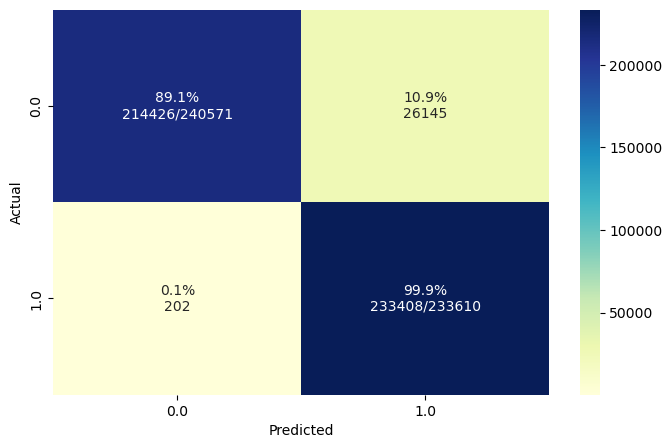

In [21]:
#Selected

y_pred_gru=(gru_ae.predict(x_vld)> 0.5)
report_heatmap(y_pred_gru,y_vld)

# Biderectional RNN

In [19]:
# Selected

from keras.layers import Bidirectional, SimpleRNN, Dense
  
B_rnn = Sequential()
B_rnn.add(SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
B_rnn.add(Bidirectional(LSTM(10)))
B_rnn.add(Dense(1, activation='sigmoid'))
B_rnn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
B_rnn.summary()
B_rnn.fit(x, y,batch_size=100,epochs=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,941
Trainable params: 2,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
14226/14226 [==============================] - 94s 6ms/step - loss: 0.1283 - accuracy: 0.9430
Epoch 2/2
14226/14226 [==============================] - 102s 7ms/step - loss: 0.1223 - accuracy: 0.9450


14819/14819 [==============================] - 30s 2ms/step
Overall Accuracy: 94.47%
--------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    240571
         1.0       0.90      1.00      0.95    233610

    accuracy                           0.94    474181
   macro avg       0.95      0.95      0.94    474181
weighted avg       0.95      0.94      0.94    474181



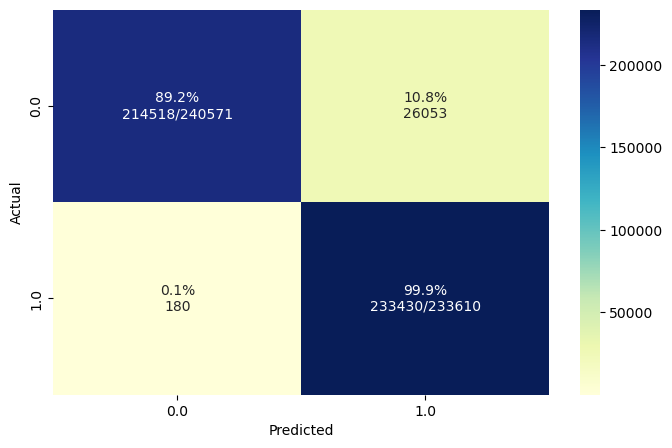

In [20]:
# Selected
y_pred_B_rnn=(B_rnn.predict(x_vld)> 0.5)
report_heatmap(y_pred_B_rnn,y_vld)

In [ ]:
#END